In [ ]:
# Data Description
"""
Films and Actors were scraped from IMDB (14k Films & 350k Actors)
Those two Collections were combined into a single object type (film_agg)
Some aggregations failed leaving a dataset of 13.6k films.
Filtered out Films shorter than 30mins to avoid outlier short films.
Filtered out Films that there wasn't a budget for.
Filtered out Films that there wasn't a revenue for.
Remaining dataset has 6991 Films
"""

"""
Not standardizing day, weekday, month features but treating them as
continuous for model simplicity
"""

In [299]:
CONT_FEATURES = [
    "max_director_film_votes",
    "director_age",
    "max_director_film_metascore",
    "max_actor_film_votes",
    "max_director_film_revenue",
    "max_actor_film_stars",
    "avg_director_film_votes",
    "max_actor_film_metascore",
    "avg_director_film_metascore",
    "avg_actor_age",
    "max_actor_film_appearances",
    "avg_actor_film_votes",
    "avg_actor_film_stars",
    "avg_actor_film_revenue",
    "avg_actor_film_appearances",
    "director_number_of_films",
    "budget",
    "length",
    "avg_actor_film_metascore",
    "max_actor_film_revenue",
    "max_director_film_stars",
    "avg_director_film_revenue",
    "avg_director_film_stars",
]

CLASS_FEATURES = [
    "day",
    "weekday",
    "month"
]

X_FEATURES = CONT_FEATURES + CLASS_FEATURES

Y_FEATURE = 'revenue'
Y_CLASS = 'revenue_class'
ID_FEATURE = 'id'

FEATURES = X_FEATURES + [Y_FEATURE, Y_CLASS, ID_FEATURE, 'profitable']

MONGO_COLUMNS = X_FEATURES + [ID_FEATURE, Y_FEATURE]
IMPUTED_FEATURES = [
    "max_director_film_votes",
    "max_director_film_metascore",
    "max_actor_film_votes",
    "max_director_film_revenue",
    "max_actor_film_stars",
    "avg_director_film_votes",
    "max_actor_film_metascore",
    "avg_director_film_metascore",
    "avg_actor_age",
    "max_actor_film_appearances",
    "avg_actor_film_votes",
    "avg_actor_film_stars",
    "avg_actor_film_revenue",
    "avg_actor_film_appearances",
    "director_number_of_films",
    "avg_actor_film_metascore",
    "max_actor_film_revenue",
    "max_director_film_stars",
    "avg_director_film_revenue",
    "avg_director_film_stars"
]

def is_profitable(row):
    return int(row['revenue']) - int(row['budget']) > 0

def predict(model, test_data, threshold):
    test_probs = model.predict_proba(test_data)
    return [1 if p[1] >= threshold else 0 for p in test_probs]

def print_predict_stats(actual, predicted):
    confusion = metrics.confusion_matrix(actual, predicted)
    true_positive = confusion[0][0]
    false_positive = confusion[0][1]
    true_negative = confusion[1][1]
    false_negative = confusion[1][0]
    print('Confusion Matrix')
    print("TP: {0}, FP: {1}, TN: {2}, FN: {3}".format(true_positive, false_positive, true_negative, false_negative))
    print(confusion)
    accuracy = float(true_positive + true_negative) / len(actual)
    error = 1 - accuracy
    print("Accuracy: {0}, Error: {1}".format(accuracy, error))
    precision = float(true_positive) / (true_positive + false_positive)
    recall = float(true_positive) / (true_positive + false_negative)
    f_one = 2 * float(precision * recall) / (precision + recall)
    print("Precision: {0}, Recall: {1}, F1: {2}".format(precision, recall, f_one))

In [327]:
# Setting up environment
import pymongo
import pandas
import numpy
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from matplotlib import pyplot
from dotenv import load_dotenv

# Loading environment variables from .env
load_dotenv()
mongo_db_host = os.environ['MONGO_DB_HOST']
mongo_db_port = int(os.environ['MONGO_DB_PORT'])
mongo_db_name = os.environ['MONGO_DB_NAME']
mongo_db_user = os.environ['MONGO_DB_USER']
mongo_db_pswd = os.environ['MONGO_DB_PSWD'] 
mongo_db_coll = os.environ['MONGO_DB_COLL']

In [35]:
# Connecting to the database
client = pymongo.MongoClient("mongodb://{0}:{1}@{2}:{3}/{4}".format(mongo_db_user, mongo_db_pswd, mongo_db_host,\
                                                                    mongo_db_port, mongo_db_name))
conn = client[mongo_db_name][mongo_db_coll]

In [90]:
# Initial Data Exploration
num_not_failed = conn.count_documents({ 'FAILED': False })
print("{0} Films with Aggregated Stats that did not fail".format(num_not_failed))

greater_than_30 = conn.count_documents({ 'FAILED': False, 'length': {'$gte': 30} })
print("{0} Films >= 30mins".format(greater_than_60))

with_budget = conn.count_documents({ 'FAILED': False, 'length': {'$gte': 30}, 'budget': {'$gt': 0} })
print("{0} Films w/ a Scraped Budget".format(with_budget))

with_revenue = conn.count_documents({ 'FAILED': False, 'length': {'$gte': 30}, 'budget': {'$gt': 0}, 'revenue': {'$gt': 0} })
print("{0} Films w/ a Revenue".format(with_revenue))

13618 Films with Aggregated Stats that did not fail
13412 Films >= 30mins
6997 Films w/ a Scraped Budget
6991 Films w/ a Revenue


In [119]:
# Get data into a pandas dataframe
mongo_films = conn.aggregate(
    [
        { '$match': { 'FAILED': False, 'length': {'$gte': 30}, 'budget': {'$gt': 0}, 'revenue': {'$gt': 0} } },
        { '$project': { field: 1 for field in MONGO_COLUMNS } }
    ]
)
films_raw = pandas.DataFrame([f for f in mongo_films])

In [304]:
# Adjust some columns (prevents having to pull Mongo again on changes)
films = films_raw.copy()
profitable_films = [is_profitable(film) for index, film in films.iterrows()]
films.drop(['_id'], axis=1, inplace=True)
films['profitable'] = profitable_films

In [305]:
# Deeper Data Exploration and Class Creation
def max_min(df, feature):
    return df[feature].max(), df[feature].min()

def print_stats(df, feature):
    max_revenue, min_revenue = max_min(df, feature)
    avg_revenue = df[feature].mean()
    med_revenue = df[feature].median()
    print("{0} Stats: Len: {1}, Max: {2}, Min: {3}, Avg: {4}, Median: {5}".format(feature, len(df), \
                                                                                  max_revenue, min_revenue, \
                                                                                  avg_revenue, med_revenue))

## Revenue Stats
print_stats(films, Y_FEATURE)

## Printing stats for other features
[print_stats(films, feature) for feature in X_FEATURES]
print('')

## Num Profitable/Not
total_films = len(films)
profitable_films = len(films.loc[films['profitable']])
print("# Profitable: {0} and # Not Profitable: {1}".format(profitable_films, total_films - profitable_films))

## Exploring Probable Classes
NUM_CLASSES = 5
sorted_films = films.sort_values(Y_FEATURE)
film_chunks = numpy.array_split(sorted_films, NUM_CLASSES)
print('')
print('Printing stats for each chunk...')
REVENUE_CLASSES = {}
for chunk in film_chunks:
    print_stats(chunk, Y_FEATURE)
    
    total_films = len(chunk)
    profitable_films = len(chunk.loc[chunk['profitable']])
    print("# Profitable: {0} and # Not Profitable: {1}".format(profitable_films, total_films - profitable_films))
    
    max_revenue, min_revenue = max_min(chunk, Y_FEATURE)
    REVENUE_CLASSES["${0}-${1}".format(min_revenue, max_revenue)] = (min_revenue, max_revenue)


revenue Stats: Len: 6991, Max: 2787965087, Min: 30, Avg: 67714944.12659132, Median: 15008161.0
max_director_film_votes Stats: Len: 6991, Max: 1883351, Min: 0, Avg: 101056.32713488772, Median: 5875.0
director_age Stats: Len: 6991, Max: 103, Min: 0, Avg: 37.30052925189529, Median: 42.0
max_director_film_metascore Stats: Len: 6991, Max: 100, Min: 0, Avg: 33.40351880989844, Median: 0.0
max_actor_film_votes Stats: Len: 6991, Max: 1883351, Min: 0, Avg: 280391.32184236875, Median: 217534.0
max_director_film_revenue Stats: Len: 6991, Max: 2187210904, Min: 0, Avg: 76314332.26090688, Median: 1826108.0
max_actor_film_stars Stats: Len: 6991, Max: 9.3, Min: 0.0, Avg: 7.243216937988171, Median: 7.4
avg_director_film_votes Stats: Len: 6991, Max: 1883351, Min: 0, Avg: 47342.99542268631, Median: 4581.0
max_actor_film_metascore Stats: Len: 6991, Max: 100, Min: 0, Avg: 72.98326419682449, Median: 75.0
avg_director_film_metascore Stats: Len: 6991, Max: 100, Min: 0, Avg: 29.213417250750965, Median: 0.0
avg_

In [306]:
# Adding/Updating Classifier Column
def find_revenue_class(row):
    revenue = row[Y_FEATURE]
    max_to_class = {REVENUE_CLASSES[classifier][1]: classifier for classifier in REVENUE_CLASSES}
    max_revenues = sorted([REVENUE_CLASSES[classifier][1] for classifier in REVENUE_CLASSES])
    for mr in max_revenues:
        if revenue <= mr:
            return max_to_class[mr]

revenue_classes = [find_revenue_class(row) for index, row in films.iterrows()]
films[Y_CLASS] = revenue_classes

In [335]:
# Features correlation with profitable
for f in [f for f in X_FEATURES]:
    price = films['revenue']
    feature = films[f]
    print("Feature {0} has a correlation of {1} w/ revenue".format(f, feature.corr(price)))

Feature max_director_film_votes has a correlation of 0.3860123302327475 w/ revenue
Feature director_age has a correlation of 0.11284211655705344 w/ revenue
Feature max_director_film_metascore has a correlation of 0.24140120506652551 w/ revenue
Feature max_actor_film_votes has a correlation of 0.25868408551082067 w/ revenue
Feature max_director_film_revenue has a correlation of 0.4872911739021101 w/ revenue
Feature max_actor_film_stars has a correlation of 0.1180772926157062 w/ revenue
Feature avg_director_film_votes has a correlation of 0.4079044334109736 w/ revenue
Feature max_actor_film_metascore has a correlation of 0.11223079567703426 w/ revenue
Feature avg_director_film_metascore has a correlation of 0.22904271874912288 w/ revenue
Feature avg_actor_age has a correlation of 0.0019150151753167999 w/ revenue
Feature max_actor_film_appearances has a correlation of 0.2969950769811964 w/ revenue
Feature avg_actor_film_votes has a correlation of 0.30546322572085477 w/ revenue
Feature avg

In [344]:
# Splitting into Testing and Training for Revenue
films_revenue_train, films_revenue_test, revenue_train, revenue_test = train_test_split(films[FEATURES], films[Y_CLASS], test_size=0.33, random_state=42)
print('Distribution in Training...')
print(revenue_train.value_counts())
print('')
print('Distribution in Testing...')
print(revenue_test.value_counts())

Distribution in Training...
$30-$530392              955
$89446268-$2787965087    951
$531997-$7454185         929
$26960191-$89431890      925
$7460797-$26924656       923
Name: revenue_class, dtype: int64

Distribution in Testing...
$7460797-$26924656       475
$26960191-$89431890      473
$531997-$7454185         469
$89446268-$2787965087    447
$30-$530392              444
Name: revenue_class, dtype: int64


In [345]:
# Splitting into Testing and Training for Profitable
films_profit_train, films_profit_test, profit_train, profit_test = train_test_split(films[FEATURES], films['profitable'], test_size=0.33, random_state=42)
print('Distribution in Training...')
print(profit_train.value_counts())
print('')
print('Distribution in Testing...')
print(profit_test.value_counts())

Distribution in Training...
True     2493
False    2190
Name: profitable, dtype: int64

Distribution in Testing...
True     1212
False    1096
Name: profitable, dtype: int64


In [346]:
# Imputing Missing Values for Agg. Stats
## Will take the average for the imputed feature for films in same class
drop_columns = [ID_FEATURE, 'profitable', Y_CLASS, Y_FEATURE]

def get_imputed_average(df, row, feature, row_cache, feature_cache):
    classifier_cache = feature_cache[row[Y_CLASS]]
    if feature not in classifier_cache:
        non_zero_loc = df.loc[df[feature] > 0]
        relv_films = non_zero_loc.loc[~non_zero_loc[ID_FEATURE].isin(row_cache[feature])]
        classifier_cache[feature] = relv_films[feature].mean()
    row_cache[feature].append(row[ID_FEATURE])
    return classifier_cache[feature]

for df, drop_columns in [(films_revenue_train, drop_columns), (films_profit_train, drop_columns), \
                         (films_revenue_test, drop_columns), (films_profit_test, drop_columns)]:
    IMPUTED_FEATURE_CACHE = {classifier: {} for classifier in REVENUE_CLASSES}
    IMPUTED_ROW_CACHE = {feature: [] for feature in IMPUTED_FEATURES}

    for feature in IMPUTED_FEATURES:
        new_values = [get_imputed_average(df, row, feature, IMPUTED_ROW_CACHE, IMPUTED_FEATURE_CACHE) if row[feature] == 0 else row[feature] for index, row in df.iterrows()]
        df[feature] = new_values
        
    num_imputed_features = len([f for f in IMPUTED_ROW_CACHE if len(IMPUTED_ROW_CACHE[f]) > 0])
    num_imputed_rows = sum([len(IMPUTED_ROW_CACHE[f]) for f in IMPUTED_ROW_CACHE])
    df.drop(drop_columns, axis=1, inplace=True)
    print("Imputed {0} values for {1} features".format(num_imputed_rows, num_imputed_features))

Imputed 20605 values for 20 features
Imputed 20605 values for 20 features
Imputed 10087 values for 20 features
Imputed 10087 values for 20 features


In [311]:
# Analyzing feature stats after imputing

## Printing stats for other features
[print_stats(films_revenue_train, feature) for feature in X_FEATURES]

print('')

max_director_film_votes Stats: Len: 4683, Max: 1883351.0, Min: 11.0, Avg: 180910.19249530957, Median: 180910.19249530957
director_age Stats: Len: 4683, Max: 103, Min: 0, Avg: 37.259449071108264, Median: 42.0
max_director_film_metascore Stats: Len: 4683, Max: 100.0, Min: 11.0, Avg: 69.88755555555555, Median: 69.88755555555555
max_actor_film_votes Stats: Len: 4683, Max: 1883351.0, Min: 8.0, Avg: 290573.2680570801, Median: 230370.0
max_director_film_revenue Stats: Len: 4683, Max: 2187210904.0, Min: 706.0, Avg: 135434751.3935411, Median: 135434751.39354113
max_actor_film_stars Stats: Len: 4683, Max: 9.3, Min: 4.4, Avg: 7.436971606944126, Median: 7.4
avg_director_film_votes Stats: Len: 4683, Max: 1387608.0, Min: 11.0, Avg: 83815.05328330206, Median: 83815.05328330207
max_actor_film_metascore Stats: Len: 4683, Max: 100.0, Min: 9.0, Avg: 75.71390493114171, Median: 75.71390493114171
avg_director_film_metascore Stats: Len: 4683, Max: 100.0, Min: 11.0, Avg: 60.93111111111112, Median: 60.93111111

In [350]:
# Feature Standardization
SCALERS = { 'revenue': {feature: None for feature in CONT_FEATURES}, 'profit': {feature: None for feature in CONT_FEATURES} }

for feature in CONT_FEATURES:
    scaler = StandardScaler()
    films_revenue_train[feature] = scaler.fit_transform(films_revenue_train[feature].values.reshape(-1, 1))
    films_revenue_test[feature] = scaler.transform(films_revenue_test[feature].values.reshape(-1, 1))
    SCALERS['revenue'][feature] = scaler
    
for feature in CONT_FEATURES:
    scaler = StandardScaler()
    films_profit_train[feature] = scaler.fit_transform(films_profit_train[feature].values.reshape(-1, 1))
    films_profit_test[feature] = scaler.transform(films_profit_test[feature].values.reshape(-1, 1))
    SCALERS['profit'][feature] = scaler
    
for feature in [Y_CLASS]:
    scaler = LabelEncoder()
    revenue_train = scaler.fit_transform(revenue_train)
    revenue_test = scaler.transform(revenue_test)
    SCALERS['revenue'][feature] = scaler

/mnt/c/Users/JNorth-Spectre/Documents/Github/bash-sandbox/ds-4400/env/lib/python3.4/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [351]:
# LR Training
estimator = LogisticRegression()
log_reg = RFE(estimator, 12)
log_reg.fit(films_profit_train, profit_train)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=12, step=1, verbose=0)

Logistic Regression is the blue line with AUC=0.6782750355327505


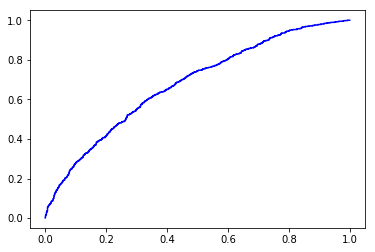

In [352]:
# LR ROC Curve
predictions = [p[1] for p in log_reg.predict_proba(films_profit_test)]
fpr, tpr, threshold = metrics.roc_curve(profit_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
print("{0} is the {1} line with AUC={2}".format('Logistic Regression', 'blue', roc_auc))
pyplot.plot(fpr, tpr, 'blue', label="AUC = {0}".format(roc_auc))

In [353]:
# LR Testing/Metrics
predictions = predict(log_reg, films_profit_test, 0.5)
print_predict_stats(profit_test, predictions)

Confusion Matrix
TP: 626, FP: 470, TN: 824, FN: 388
[[626 470]
 [388 824]]
Accuracy: 0.6282495667244368, Error: 0.37175043327556323
Precision: 0.5711678832116789, Recall: 0.6173570019723866, F1: 0.5933649289099526


In [ ]:
# SVM (SVM)
"""
Training a SVM model to predict if a movie will be profitable or not
"""

In [323]:
# SVM Training
svm = SVC(probability=True)
svm.fit(films_profit_train, profit_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVM is the red line with AUC=0.6557448628074485


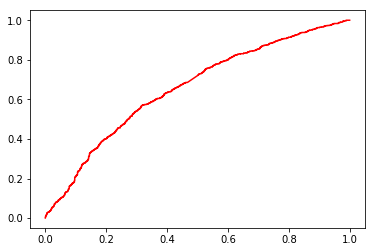

In [341]:
# SVM ROC Curve
predictions = [p[1] for p in svm.predict_proba(films_profit_test)]
fpr, tpr, threshold = metrics.roc_curve(profit_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
print("{0} is the {1} line with AUC={2}".format('SVM', 'red', roc_auc))
pyplot.plot(fpr, tpr, 'red', label="AUC = {0}".format(roc_auc))

In [324]:
# SVM Testing/Metrics
predictions = predict(svm, films_profit_test, 0.5)
print_predict_stats(profit_test, predictions)

Confusion Matrix
TP: 546, FP: 550, TN: 875, FN: 337
[[546 550]
 [337 875]]
Accuracy: 0.615684575389948, Error: 0.38431542461005197
Precision: 0.4981751824817518, Recall: 0.6183465458663646, F1: 0.5517938352703385


In [ ]:
# Random Forest (RF)
"""
Training a Random Forest to predict what revenue range a film will fall in
"""

In [343]:
# RF Training
tree_nums = [10, 50, 100, 1000]
le = SCALERS['revenue'][Y_CLASS]
class_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('Class Mapping:')
print(class_name_mapping)
print('')

for tree_num in tree_nums:
    print("Tree Num = {0}".format(tree_num))
    rf = RandomForestClassifier(n_estimators=tree_num)
    rf.fit(films_revenue_train, revenue_train)
    predictions = rf.predict(films_revenue_test)
    print('Testing Stats')
    print(metrics.classification_report(revenue_test, predictions))
    print('')

Class Mapping:
{'$89446268-$2787965087': 4, '$531997-$7454185': 2, '$26960191-$89431890': 0, '$7460797-$26924656': 3, '$30-$530392': 1}

Tree Num = 10
Testing Stats
             precision    recall  f1-score   support

          0       0.32      0.45      0.37       473
          1       0.50      0.58      0.53       444
          2       0.35      0.29      0.31       469
          3       0.29      0.18      0.23       475
          4       0.60      0.62      0.61       447

avg / total       0.41      0.42      0.41      2308


Tree Num = 50
Testing Stats
             precision    recall  f1-score   support

          0       0.34      0.39      0.36       473
          1       0.56      0.58      0.57       444
          2       0.38      0.33      0.35       469
          3       0.34      0.29      0.31       475
          4       0.62      0.67      0.64       447

avg / total       0.44      0.45      0.44      2308


Tree Num = 100
Testing Stats
             precision    re